# Train the TD_VAE after hyperparameter tuning
This notebooks trains the TD_VAE model after hyperparameter tuning. 
The model is trained on the full dataset and the trained model is saved to disk.

In [1]:
import json
import logging
import pathlib
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import tqdm
import umap
from matplotlib import gridspec
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

utils_path = pathlib.Path("../../utils/").resolve(strict=True)
sys.path.append(str(utils_path))

from model import TD_VAE, DBlock, Decoder, PreProcess
from prep_data import MNIST_Dataset
from rollout import rollout_func

/home/lippincm/miniforge3/envs/tdvae_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Build a TD-VAE model
# dataset dependent constants

X_DIM = 784  # dataset dependent
PROCESSED_X_DIM = 784  # dataset dependent
# Set constants
samples_per_seq = 20
time_constant_max = 16  # There are 20 frames total
time_jump_options = [1, 2, 3, 4]  # Jump up to 4 frames away
num_epochs = 500

In [2]:
# set path to the MNIST images
mnist_pickle_path = pathlib.Path("../../data/mnist/MNIST.pkl").resolve(strict=True)
# create the log directory if it does not exist
log_path = pathlib.Path("../log/").resolve()
log_path.mkdir(exist_ok=True)
log_file_path = pathlib.Path("../log/loginfo.txt").resolve()
# set and make the models directory
models_path = pathlib.Path("../models/").resolve()
models_path.mkdir(exist_ok=True, parents=True)
# set the path to the results directory
results_path = pathlib.Path("../results/").resolve()
results_path.mkdir(exist_ok=True, parents=True)
# set the path to the best params file
params_path = pathlib.Path("../models/best_params.json").resolve(strict=True)

In [3]:
# set up logging
logger = logging.getLogger(__name__)
# make the log directory
pathlib.Path("../log").mkdir(exist_ok=True)
logging.basicConfig(
    filename=str(pathlib.Path(log_path / "training_log.log")), level=logging.INFO
)

In [4]:
with open(mnist_pickle_path, "rb") as file_handle:
    MNIST = pickle.load(file_handle)

# get the MNIST data keys
print(MNIST.keys())
MNIST["train_image"].shape

dict_keys(['train_image', 'train_label', 'test_image', 'test_label'])


(60000, 28, 28)

## Set parameters

In [5]:
# read in the parameters

with open(params_path, "r") as file_handle:
    best_params = json.load(file_handle)

batch_size = best_params["batch_size"]

In [6]:
# create the data class
# this class makes a rolling window of the data
data = MNIST_Dataset(
    MNIST["train_image"],
    MNIST["train_label"],
    binary=True,
    number_of_frames=samples_per_seq,
)
# create the data loader
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [7]:
# build the best model
tdvae = TD_VAE(
    x_size=X_DIM,
    processed_x_size=PROCESSED_X_DIM,
    b_size=best_params["belief_state_size"],
    z_size=best_params["state_size"],
    d_block_hidden_size=best_params["d_block_hidden_size"],
    decoder_hidden_size=best_params["decoder_hidden_size"],
    layers=best_params["n_layers"],
    samples_per_seq=samples_per_seq,
    t_diff_min=1,
    t_diff_max=16,
)
# best optimizer
if best_params["optimizer"] == "SGD":
    optimizer_kwargs = {"momentum": best_params["momentum"]}
    optimizer = optim.SGD(
        tdvae.parameters(), lr=best_params["learning_rate"], **optimizer_kwargs
    )
elif best_params["optimizer"] == "RMSprop":
    optimizer_kwargs = {
        "alpha": best_params["alpha"],
        "momentum": best_params["momentum"],
        "eps": best_params["epsilon"],
    }
    optimizer = optim.RMSprop(
        tdvae.parameters(), lr=best_params["learning_rate"], **optimizer_kwargs
    )
elif best_params["optimizer"] == "Adam":
    optimizer = optim.Adam(tdvae.parameters(), lr=best_params["learning_rate"])
else:
    raise ValueError("Invalid optimizer")


tdvae = tdvae.cuda()
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Device: {device}")

In [8]:
# make model save directory
model_save_dir = pathlib.Path("../models").resolve()
model_save_dir.mkdir(parents=True, exist_ok=True)

epoch:    0, loss: 290.2296
epoch:    1, loss: 232.2723
epoch:    2, loss: 210.5991
epoch:    3, loss: 215.7642
epoch:    4, loss: 202.4542
torch.Size([96, 20, 784])


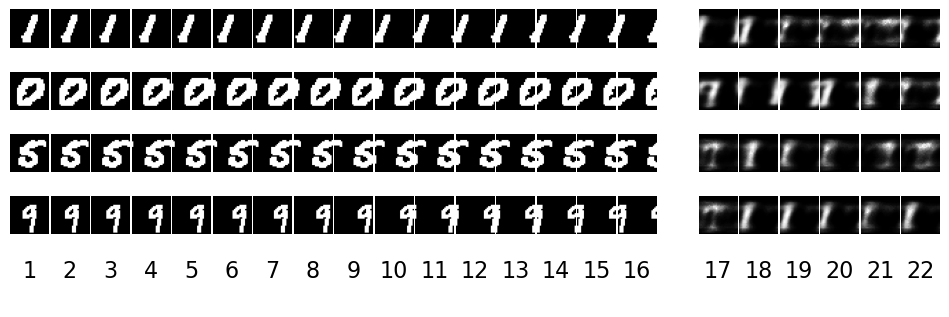

In [9]:
# Train the model

for epoch in range(num_epochs):
    epoch_loss = 0

    for batch, (idx, images) in enumerate(data_loader):
        batch_counter = 0
        batch_loss = 0
        images = images["image"].cuda()
        # Make a forward step of preprocessing and LSTM
        # foward function returns a tuple of:
        # images, t2, qs_z1_z2_b1_mu, qs_z1_z2_b1_logvar, pb_z1_b1_mu,
        # pb_z1_b1_logvar, qb_z2_b2_mu, qb_z2_b2_logvar,
        # qb_z2_b2, pt_z2_z1_mu, pt_z2_z1_logvar, pd_x2_z2
        forward_return_tuple = tdvae.forward(images)

        # Randomly sample a time step and jumpy step
        t_1 = np.random.choice(time_constant_max)
        t_2 = t_1 + np.random.choice(time_jump_options)

        # Calculate loss function based on two time points
        loss, bce_diff, kl_div_qs_pb, kl_shift_qb_pt, bce_optimal = (
            tdvae.calculate_loss(forward_return_tuple)
        )
        if loss.isnan():
            print("loss is nan")
            pass
        elif loss.isinf():
            print("loss is inf")
            pass
        elif loss.item() == 0:
            print("loss is zero")
            pass
        elif loss.item() < 0:
            print("loss is negative")
            pass
        elif loss.item() > 0:
            batch_counter += 1
            batch_loss += loss.item()
            # must clear out stored gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    epoch_loss += batch_loss / batch_counter
    logger.info(f"epoch: {epoch}, loss: {epoch_loss}")
    print("epoch: {:>4d}, loss: {:.4f}".format(epoch, epoch_loss))

    # save the model every n epochs and plot the jumpy reconstruction
    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": tdvae.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss,
            },
            pathlib.Path(model_save_dir / f"model_epoch_{epoch}.pt").resolve(),
        )
        # loss, bce_diff, kl_div_qs_pb, kl_shift_qb_pt, bce_optimal
        rollout_stack = tdvae.rollout(x=images, t=16, n=20, z_rollout=False)
        print(rollout_stack.shape)
        rollout_func(
            rollout_stack=rollout_stack,
            images=images,
            epoch=epoch,
            batch_size=4,
            save_path=pathlib.Path(model_save_dir).resolve(),
            t1=16,
            t2=21,
        )
# save the final model
torch.save(
    {
        "epoch": epoch,
        "model_state_dict": tdvae.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    },
    pathlib.Path(model_save_dir / f"model_epoch_final.pt").resolve(),
)

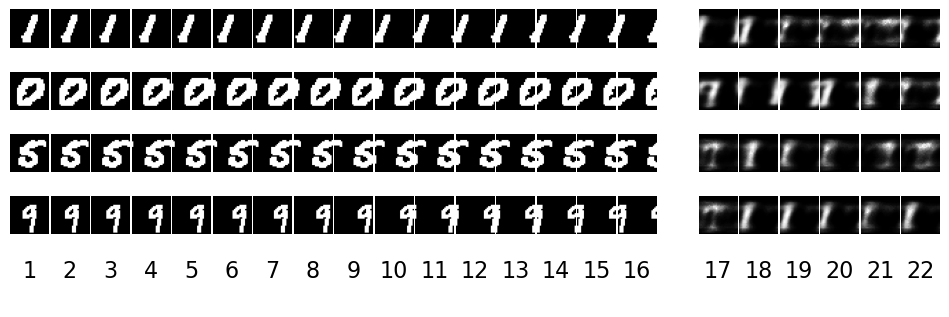

In [10]:
rollout_func(
    rollout_stack=rollout_stack,
    images=images,
    epoch="Final",
    batch_size=4,
    save_path=pathlib.Path(model_save_dir).resolve(),
    t1=16,
    t2=21,
)

In [11]:
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
current_z_list = []
for batch, (idx, images) in enumerate(data_loader):
    batch_counter = 0
    batch_loss = 0
    images = images["image"].cuda()
    current_z = tdvae.rollout(images, 16, 19, z_rollout=True)
    current_z_list.append(current_z.detach().cpu().numpy())
    del current_z

# flatten the list of arrays
current_z_list = [item for sublist in current_z_list for item in sublist]
# current_z_list = [item for sublist in current_z_list for item in sublist]
print(len(current_z_list))

60000


In [12]:
current_z_dict = {}
for i in enumerate(current_z_list):
    current_z_dict[i[0]] = i[1]
current_z_df = pd.DataFrame(current_z_dict).T
print(current_z_df.shape)
# save the current z dataframe
current_z_df.to_parquet(pathlib.Path("../output/current_z_df.parquet").resolve())

(60000, 168)


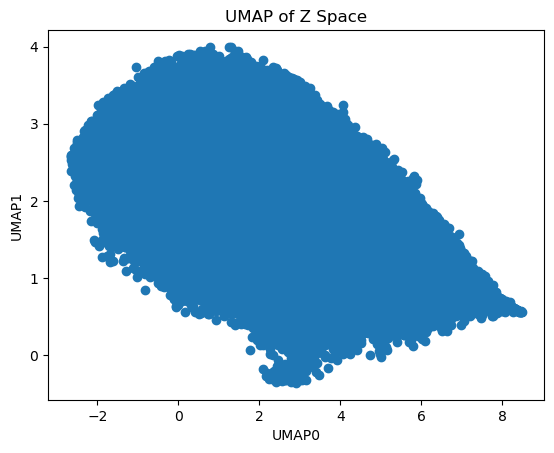

In [13]:
# get the umap of the z_space and current_z
reducer = umap.UMAP()
current_z_umap = reducer.fit_transform(current_z_df)
umap_df_of_z = pd.DataFrame(current_z_umap)
umap_df_of_z.rename(columns={0: "UMAP0", 1: "UMAP1"}, inplace=True)
# save the umap dataframe
umap_df_of_z.to_parquet(pathlib.Path("../output/umap_df_of_z.parquet").resolve())

# plot the umap
plt.scatter(umap_df_of_z["UMAP0"], umap_df_of_z["UMAP1"])
plt.title("UMAP of Z Space")
plt.xlabel("UMAP0")
plt.ylabel("UMAP1")
plt.show()